# Housing in Iowa

This is a kaggle competition. You can find the competition and data here:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


with Mkrtich Ohanyan

In [70]:
import xgboost
import numpy as np 
import pandas as pd 
import os

#define training data and testing data
training_data=os.path.abspath('train.csv')
testing_data=os.path.abspath('test.csv')

In [71]:
#read the csv files
train=pd.read_csv(training_data)
test=pd.read_csv(testing_data)

### We see below that we are trying to predict SalePrice using the following variables:

'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
'MoSold', 'YrSold', 'Neighborhood', 'ExterQual', 'BsmtQual',
'GarageFinish', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC',
'MasVnrType', 'BsmtExposure',

In [72]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [73]:
#read in tableau images
tableau1=os.path.abspath('Tableau1.png')
tableau2=os.path.abspath('Tableau2.png')
tableau3=os.path.abspath('Tableau3.png')

Next, we will analyze the following three images. There are many features which have redundant "zeros. In the case of 2ndFlrSF, we see that there are a lot of zeros because there is no 2nd Floor. It might make sense to get rid of the zeros or combine the first floor and second floor square footage.

In the third set of graphs, we see that some discrete features have one variable which gives us extremely high sale prices while the rest of the variables give around the same sale price. For example, in the Building type graph, 1Family homes correlates with high sale price, while the rest of the building types correlate with lower sale price. Similarly, Unf BsmtFinType2 gives us high sale price while the rest of the BsmtFinType2 options give us lower sale price. On the other hand, Bsmt Qual gives us less of an indication of SalePrice.

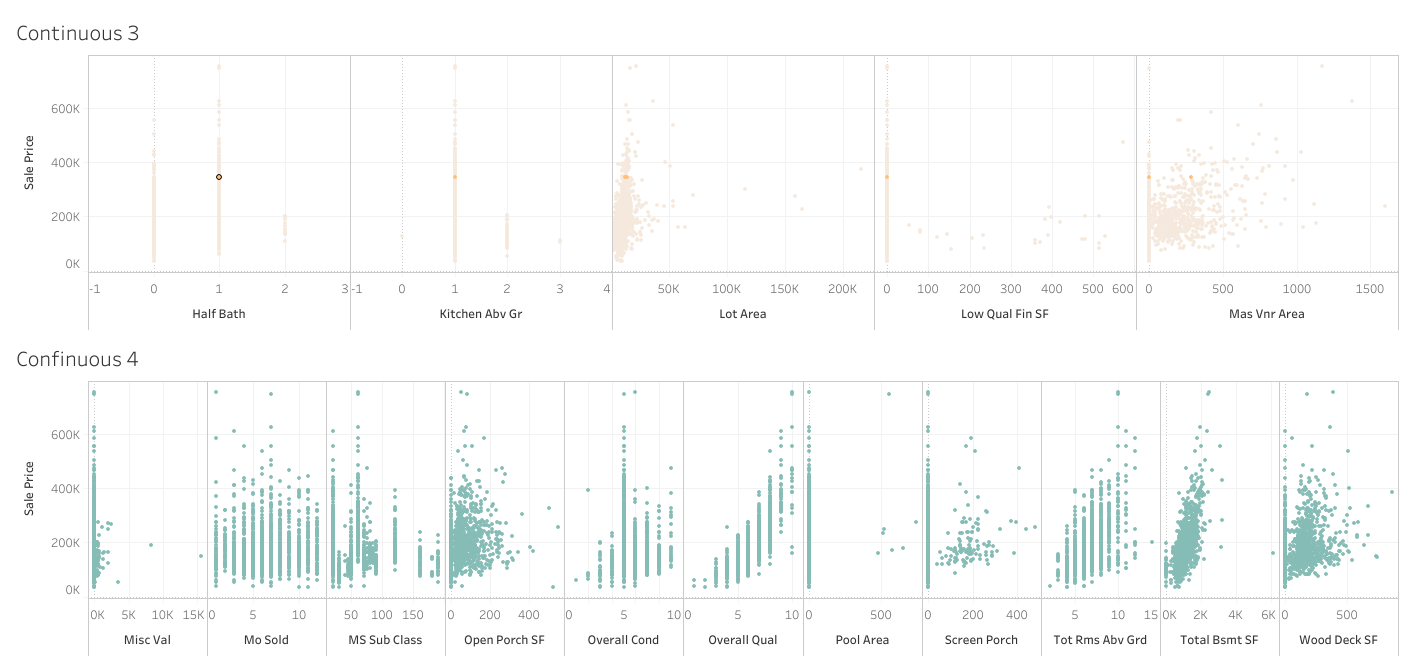

In [74]:
#Show the first image
from IPython.display import Image
Image(tableau1)

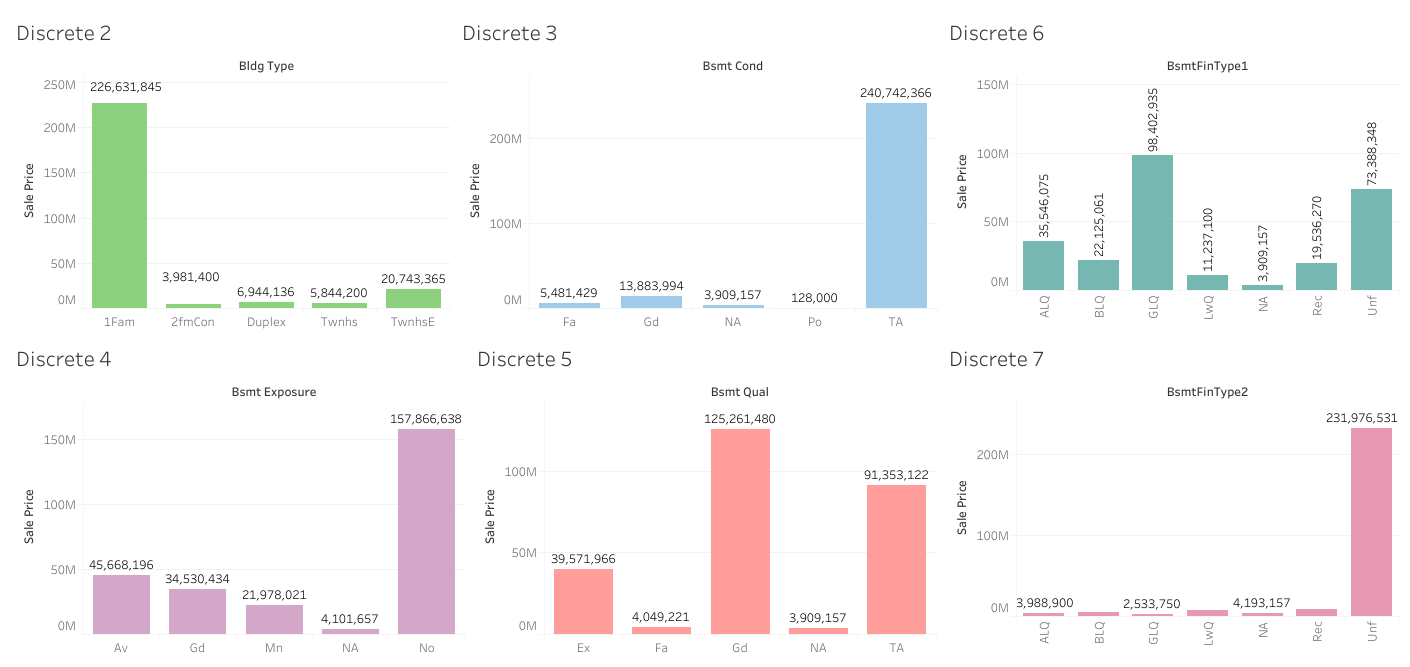

In [75]:
Image(tableau2)

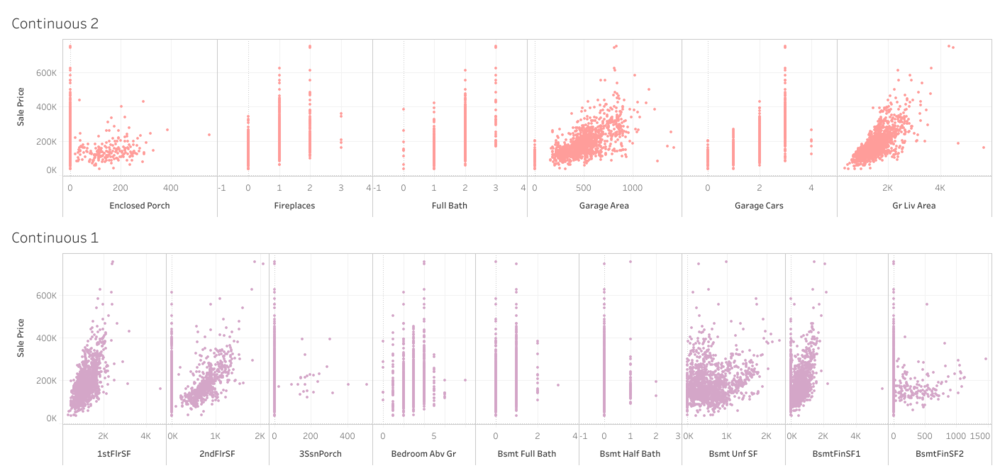

In [76]:
Image(tableau3)

In [77]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### We are going to drop the variables with a high percentage of missing data. 

In [78]:
to_drop=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
train=train.drop(to_drop,axis=1)
test=test.drop(to_drop,axis=1)

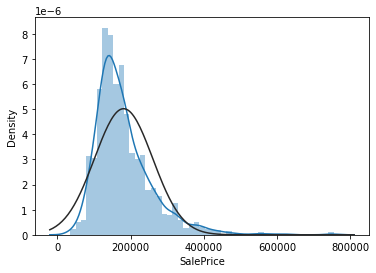

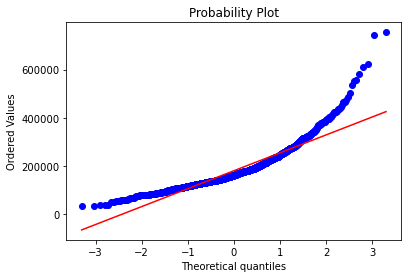

In [79]:
#histogram and normal probability plot
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

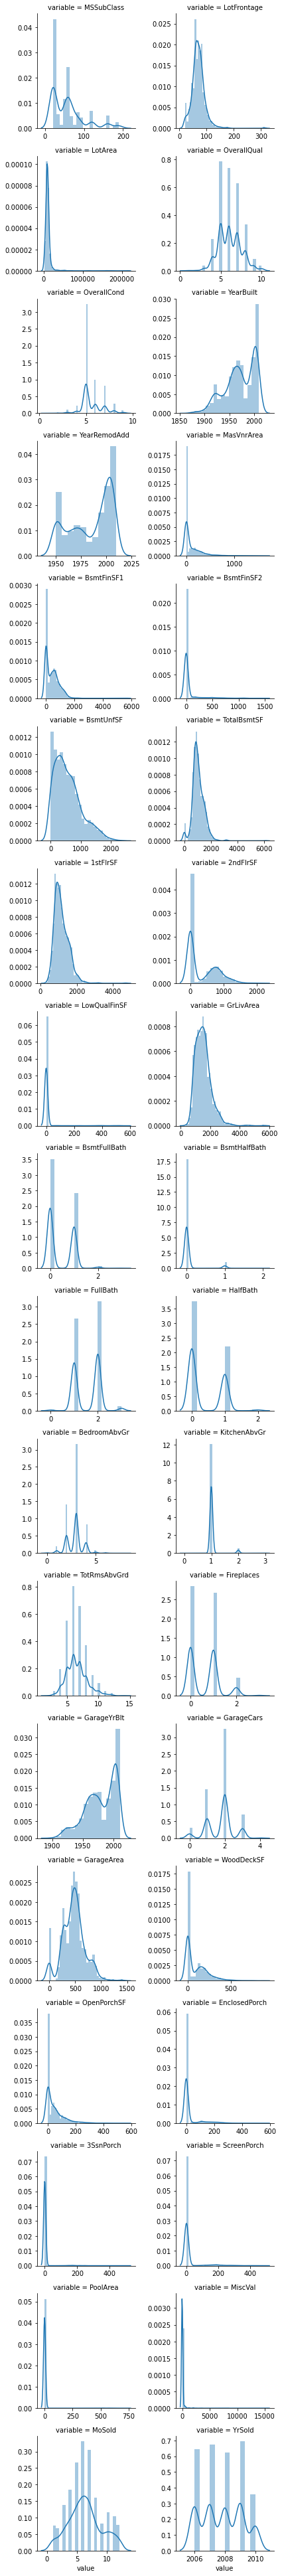

In [80]:
###We split the features into 'quantitative' and 'qualitative' features.
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')


qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


In [81]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

In [82]:
for c in qualitative:
    test[c] = test[c].astype('category')
    if test[c].isnull().any():
        test[c] = test[c].cat.add_categories(['MISSING'])
        test[c] = test[c].fillna('MISSING')

### In place of Nan's, I inserted the column's mean:

In [83]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
train[quantitative] = my_imputer.fit_transform(train[quantitative])
test[quantitative] = my_imputer.fit_transform(test[quantitative])

In [84]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

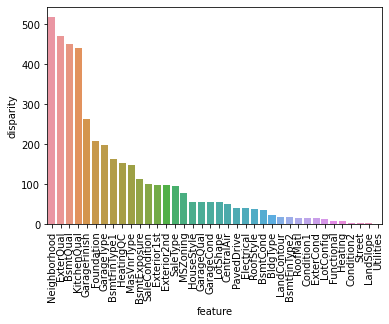

In [85]:
a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

### I choose the top 10 qualitative features. 

In [86]:
qual_features=['Neighborhood','ExterQual','BsmtQual','GarageFinish','Foundation','GarageType','BsmtFinType1','HeatingQC','MasVnrType','BsmtExposure']
target=['SalePrice']
need_id=['Id']
train=train[quantitative+qual_features+target+need_id]
test=test[quantitative+qual_features+need_id]
train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,BsmtQual,GarageFinish,Foundation,GarageType,BsmtFinType1,HeatingQC,MasVnrType,BsmtExposure,SalePrice,Id
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Gd,RFn,PConc,Attchd,GLQ,Ex,BrkFace,No,208500,1
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Gd,RFn,CBlock,Attchd,ALQ,Ex,None,Gd,181500,2
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Gd,RFn,PConc,Attchd,GLQ,Ex,BrkFace,Mn,223500,3
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,TA,Unf,BrkTil,Detchd,ALQ,Gd,None,No,140000,4
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Gd,RFn,PConc,Attchd,GLQ,Ex,BrkFace,Av,250000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,Gd,RFn,PConc,Attchd,Unf,Ex,None,No,175000,1456
1456,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,Gd,Unf,CBlock,Attchd,ALQ,TA,Stone,No,210000,1457
1457,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,TA,RFn,Stone,Attchd,GLQ,Ex,None,No,266500,1458
1458,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,TA,Unf,CBlock,Attchd,GLQ,Gd,None,Mn,142125,1459


In [87]:
neigh1=train['SalePrice'].groupby(train['Neighborhood']).mean()
[neigh1.sort_values().index]

[CategoricalIndex(['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'Edwards',
                   'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes',
                   'Mitchel', 'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn',
                   'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Veenker',
                   'Timber', 'StoneBr', 'NridgHt', 'NoRidge'],
                  categories=['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', ...], ordered=False, name='Neighborhood', dtype='category')]

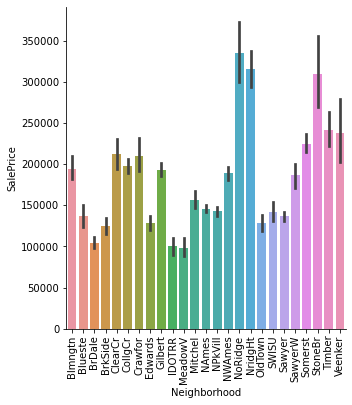

In [88]:
sns.catplot(x="Neighborhood", y="SalePrice", kind="bar", data=train)
x=plt.xticks(rotation=90)

#### In the following commented out cells, I ordered the variables in terms of SalePrice.

In [89]:
# ExterQual1=train['SalePrice'].groupby(train['ExterQual']).mean()
# [ExterQual1.sort_values().index]

In [90]:
# BsmtQual1=train['SalePrice'].groupby(train['BsmtQual']).mean()
# [BsmtQual1.sort_values().index]

In [91]:
# GarageFinish1=train['SalePrice'].groupby(train['GarageFinish']).mean()
# [GarageFinish1.sort_values().index]

In [92]:
# Foundation1=train['SalePrice'].groupby(train['Foundation']).mean()
# [Foundation1.sort_values().index]

In [93]:
# GarageType1=train['SalePrice'].groupby(train['GarageType']).mean()
# [GarageType1.sort_values().index]

In [94]:
# BsmtFinType11=train['SalePrice'].groupby(train['BsmtFinType1']).mean()
# [BsmtFinType11.sort_values().index]

In [95]:
# HeatingQC1=train['SalePrice'].groupby(train['HeatingQC']).mean()
# [HeatingQC1.sort_values().index]

In [96]:
# MasVnrType1=train['SalePrice'].groupby(train['MasVnrType']).mean()
# [MasVnrType1.sort_values().index]

In [97]:
# BsmtExposure1=train['SalePrice'].groupby(train['BsmtExposure']).mean()
# [BsmtExposure1.sort_values().index]

### I use OrdinalEncoder.

In [98]:
from sklearn.preprocessing import OrdinalEncoder
Neighborhood2 = ['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'Edwards',
                   'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes',
                   'Mitchel', 'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn',
                   'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Veenker',
                   'Timber', 'StoneBr', 'NridgHt', 'NoRidge']
ExterQual2=['Fa', 'TA', 'Gd', 'Ex']
BsmtQual2=['MISSING', 'Fa', 'TA', 'Gd', 'Ex']
GarageFinish2=['MISSING', 'Unf', 'RFn', 'Fin']
Foundation2=['Slab', 'BrkTil', 'CBlock', 'Stone', 'Wood', 'PConc']
GarageType2=['MISSING', 'CarPort', 'Detchd', '2Types', 'Basment',
                   'Attchd', 'BuiltIn']
BsmtFinType12=['MISSING', 'Rec', 'BLQ', 'LwQ', 'ALQ', 'Unf', 'GLQ']
HeatingQC2=['Po', 'Fa', 'TA', 'Gd', 'Ex']
MasVnrType2=['BrkCmn', 'None', 'BrkFace', 'MISSING', 'Stone']
BsmtExposure2=['MISSING', 'No', 'Mn', 'Av', 'Gd']


encoder = OrdinalEncoder(categories=[Neighborhood2,ExterQual2,BsmtQual2,GarageFinish2,Foundation2,GarageType2,BsmtFinType12,HeatingQC2,MasVnrType2,BsmtExposure2])

In [99]:
my_array=encoder.fit_transform(train[qual_features]).reshape((1460,10)).tolist()
my_array_test=encoder.fit_transform(test[qual_features]).reshape((1459, 10)).tolist()

In [100]:
train[qual_features]=my_array
test[qual_features]=my_array_test

### Train-test-split

In [101]:
from sklearn.model_selection import train_test_split
X=train.drop('SalePrice',axis=1)
y=train['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)


### I try logistic regression to compare.

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_log_error

logreg = LogisticRegression(random_state=0,solver='liblinear').fit(X_train, y_train)
y_pred=logreg.predict(X_test)
               
mean_squared_log_error(y_test,y_pred)

0.09179768261023952

### XGboost works well.

In [103]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score 
cat1 = XGBRegressor(n_estimators=1000,
                           learning_rate=0.01,
                           early_stopping_rounds=10,
                             max_depth=5).fit(X_train,y_train)
y_cat=cat1.predict(X_test)
mean_squared_log_error(y_test,y_cat)

[14:54:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.015894559574997552

In [104]:
predicted_prices=cat1.predict(test)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices.ravel()})
my_submission.to_csv('submission.csv', index=False)

In [105]:
print(my_submission)

        Id      SalePrice
0     1461  127598.601562
1     1462  151800.171875
2     1463  184886.453125
3     1464  189685.453125
4     1465  204074.796875
...    ...            ...
1454  2915   78876.843750
1455  2916   81258.710938
1456  2917  166888.140625
1457  2918  113450.140625
1458  2919  200621.015625

[1459 rows x 2 columns]
